## Imports

In [1]:
import torch
from lime import lime_image
import numpy as np
from skimage.segmentation import mark_boundaries

In [11]:
%run models/__init__.py

In [3]:
%run utils.py

In [4]:
%run utilsT.py

In [5]:
%run utilsTesting.py

In [6]:
%run -n train.py

In [7]:
device = get_torch_device(gpu=False)
device

device(type='cpu')

## Load model

In [8]:
run_name = "1121_180210_resnet_v3_wd0.5_Cardiomegaly"
# run_name = "0107_132136_resnet_v3_Cardiomegaly"
# run_name = "0115_223657_resnet_v3_os_Cardiomegaly"
# run_name = "1103_132133_Cardiomegaly"

In [9]:
%run models/__init__.py

In [12]:
model, model_name, optimizer, opt_name, loss_name, loss_params, chosen_diseases = load_model(
    BASE_DIR, run_name, device=device, force_multiple_gpu=False)
model = model.to(device)

In [13]:
_ = model.train(False)

## Load data

In [14]:
BATCH_SIZE = 4

In [15]:
%%time
dataset, dataloader = prepare_data(DATASET_DIR, "test", ALL_DISEASES, BATCH_SIZE, max_images=None)
n_images, n_diseases = dataset.size()
n_images, n_diseases

CPU times: user 28.2 s, sys: 87.1 ms, total: 28.3 s
Wall time: 28.3 s


(25596, 14)

In [16]:
images, labels, names, _, _ = next(iter(dataloader))
images.shape

torch.Size([4, 3, 512, 512])

# LIME

## Prepare functions for LIME

### Transform functions for images

In [17]:
pil_transf, tensor_transf = get_image_transformation_for_lime()

In [18]:
def batch_predict(images):
    batch = torch.stack(tuple(tensor_transf(img) for img in images), dim=0).to(device)
    
    preds, _, _ = model(batch)

    return preds.detach().cpu().numpy()

#### Test `batch_predict`

In [16]:
image_name = "00012288_000.png"
pil_image = load_pil_image(image_name)
preds = batch_predict([pil_transf(pil_image)])
preds

array([[0.10357809]], dtype=float32)

## LIME explainer

In [27]:
def plot_explanation(explanation, num_features=10, hide_rest=False):
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                positive_only=False,
                                                num_features=num_features,
                                                hide_rest=hide_rest)
    plt.imshow(mark_boundaries(temp/255.0, mask))

In [28]:
explainer = lime_image.LimeImageExplainer()

def predict_and_explain(image_name,
                        top_labels=5,
                        num_features=10,
                        hide_color=0,
                        distance_metric='cosine',
                        segmentation_fn=None):
    pil_image = load_pil_image(image_name)
    
    explanation = explainer.explain_instance(np.array(pil_transf(pil_image)),
                                             batch_predict,
                                             top_labels=top_labels,
                                             hide_color=hide_color,
                                             distance_metric=distance_metric,
                                             segmentation_fn=segmentation_fn,
                                             num_samples=1000)
    
    plot_explanation(explanation, num_features=num_features)
    
    return explanation

In [29]:
def plot_lime_and_activation(image_name, num_features=10, thresh=0.5, show_bboxes=True,
                             segmentation_fn=None, subplots=2):
    _, gt, pred, bboxes, activation = gen_image_with_bbox(model, dataset, image_name, chosen_diseases, device)

    plt.figure(figsize=(15, 5))

    plt.subplots_adjust(wspace=0.5)
    plt.subplot(1, subplots, 1)
    plt.title(image_name)
    expl = predict_and_explain(image_name, num_features=num_features, segmentation_fn=segmentation_fn)
    
    if show_bboxes:
        plot_bboxes(bboxes)
    
    plt.subplot(1, subplots, 2)
    plot_activation(activation, pred, gt, chosen_diseases, disease_name=chosen_diseases[0])
    
    print(f"Ground truth: {gt[0]}")
    print(f"Prediction: {pred[0]:.4f}")
    print("R^2 of the linear explanation: ", expl.score)
    
    return expl

In [30]:
def get_cms_names(run_name, disease_name):
    fname = CMS_DIR + "/" + run_name + "_test_names"

    TP, FP, TN, FN, cm = load_cms_names(fname, disease_name)
    print(cm)
    return TP, FP, TN, FN, cm

In [31]:
TP, FP, TN, FN, cm = get_cms_names(run_name, "Cardiomegaly")

[[24048   479]
 [  852   217]]


## Test some examples

100% |########################################################################|


Ground truth: 1
Prediction: 0.1036
R^2 of the linear explanation:  0.2394953600888451


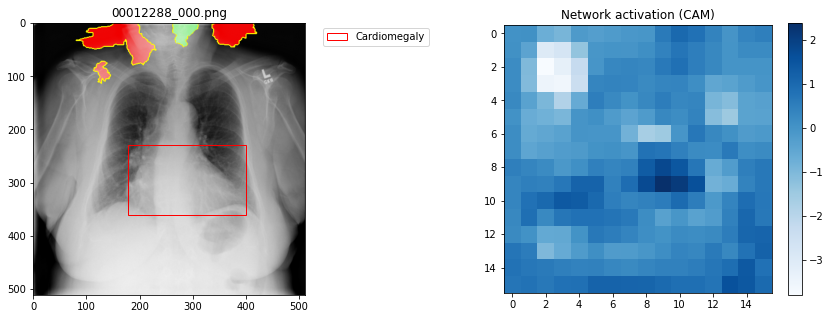

In [21]:
image_name = "00012288_000.png"
expl = plot_lime_and_activation(image_name, num_features=5)

100% |########################################################################|


Ground truth: 1
Prediction: 0.0034
R^2 of the linear explanation:  0.3463720014907326


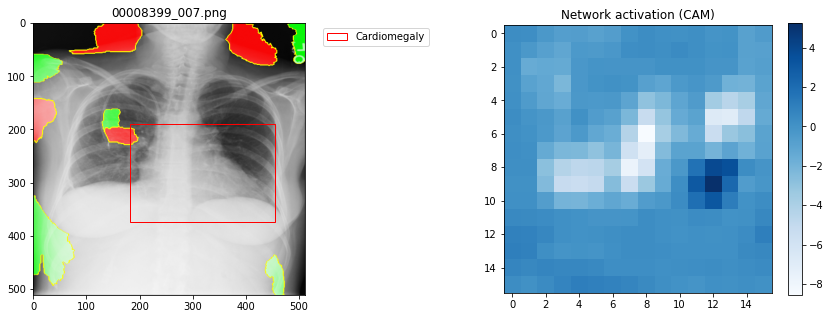

In [22]:
image_name = "00008399_007.png"
expl = plot_lime_and_activation(image_name)

In [70]:
expl.local_pred

array([-0.00830024])

100% |########################################################################|


Ground truth: 1
Prediction: 0.0146
R^2 of the linear explanation:  0.29493315374740214


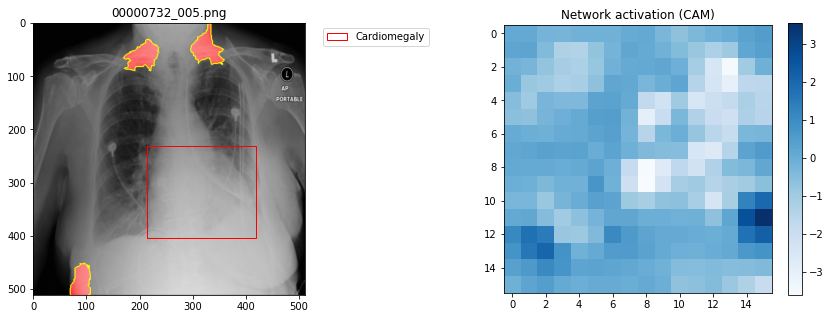

In [23]:
image_name = "00000732_005.png"
expl = plot_lime_and_activation(image_name, num_features=3)

100% |########################################################################|


Ground truth: 1
Prediction: 0.7105
R^2 of the linear explanation:  0.28093846868189354


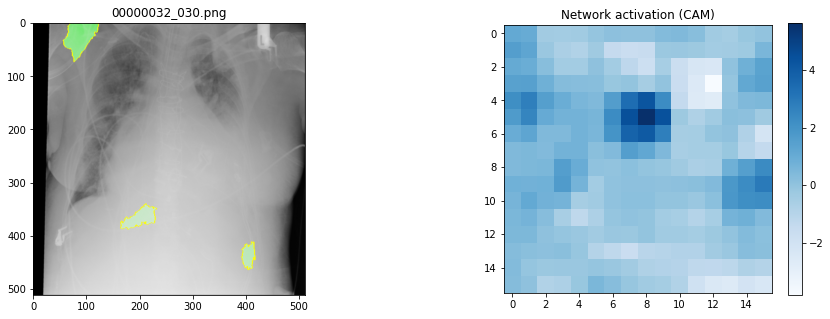

In [26]:
expl = plot_lime_and_activation(TP[0], num_features=3)

100% |########################################################################|


Ground truth: 1
Prediction: 0.5962
R^2 of the linear explanation:  0.21255827905913094


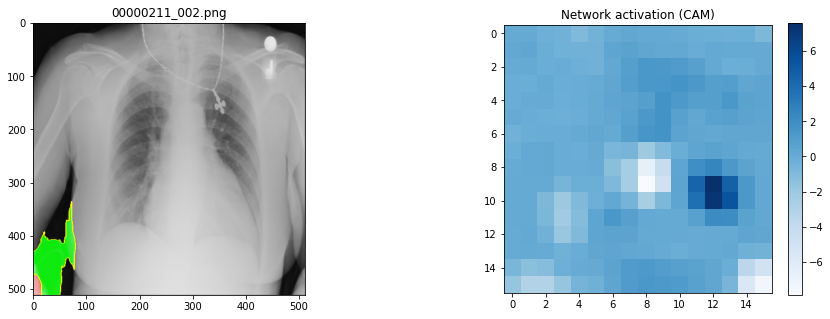

In [27]:
expl = plot_lime_and_activation(TP[1], num_features=3)

100% |########################################################################|


Ground truth: 0
Prediction: 0.0001
R^2 of the linear explanation:  0.24821746716328075


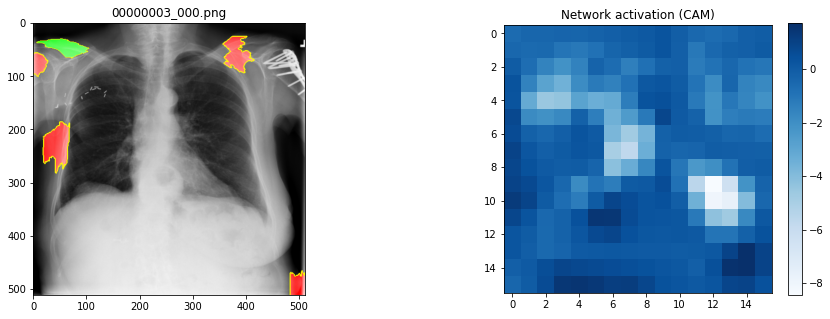

In [28]:
expl = plot_lime_and_activation(TN[0], num_features=5)

100% |########################################################################|


Ground truth: 0
Prediction: 0.0026
R^2 of the linear explanation:  0.28358740131004145


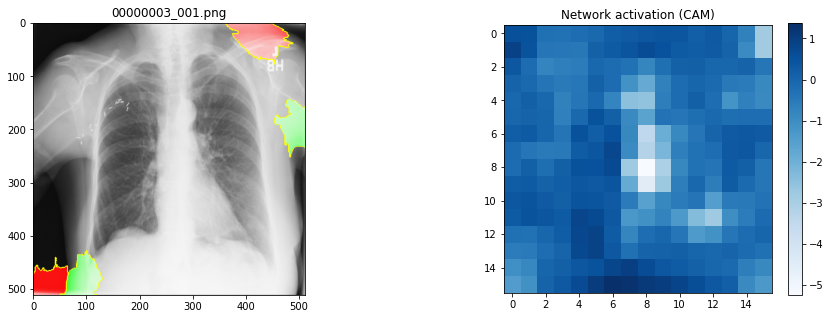

In [29]:
expl = plot_lime_and_activation(TN[1], num_features=5)

100% |########################################################################|


Ground truth: 0
Prediction: 0.8094
R^2 of the linear explanation:  0.28840723422415393


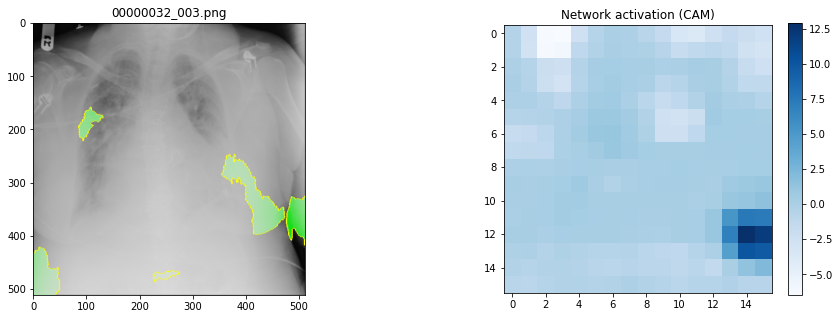

In [30]:
expl = plot_lime_and_activation(FP[0], num_features=5)

100% |########################################################################|


Ground truth: 0
Prediction: 0.7323
R^2 of the linear explanation:  0.24946263182531814


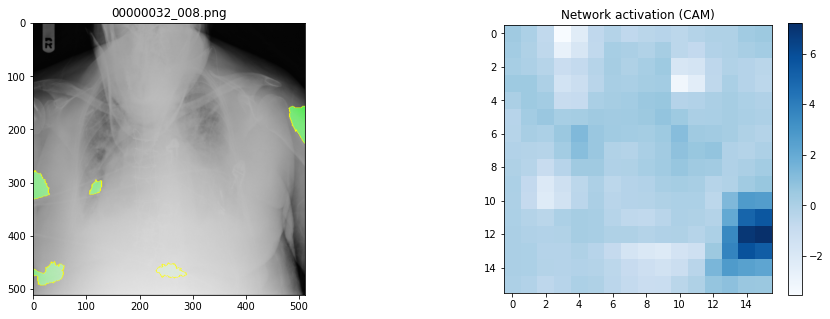

In [31]:
expl = plot_lime_and_activation(FP[1], num_features=5)

100% |########################################################################|


Ground truth: 0
Prediction: 0.9379
R^2 of the linear explanation:  0.26424101932769073


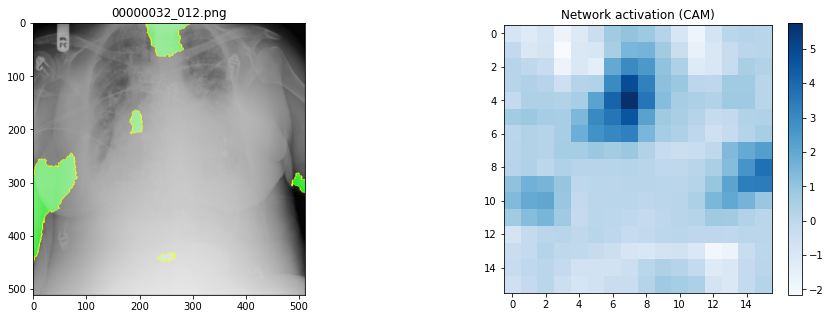

In [32]:
expl = plot_lime_and_activation(FP[2], num_features=5)

100% |########################################################################|


Ground truth: 0
Prediction: 0.5709
R^2 of the linear explanation:  0.26431926872093814


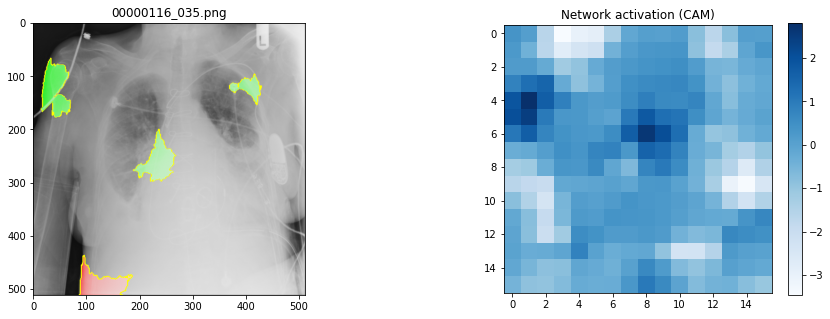

In [33]:
expl = plot_lime_and_activation(FP[3], num_features=5)

100% |########################################################################|


Ground truth: 0
Prediction: 0.6794
R^2 of the linear explanation:  0.2637961610872712


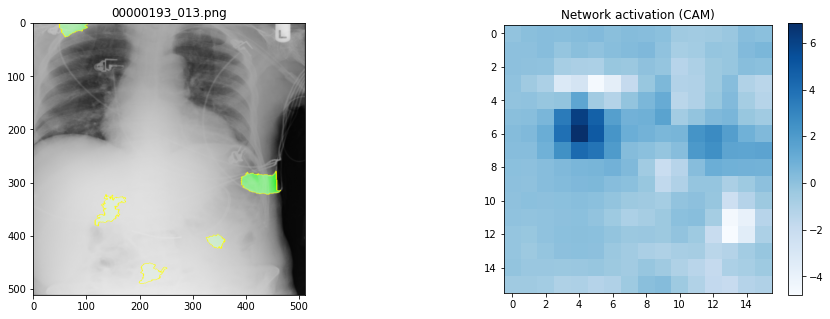

In [34]:
expl = plot_lime_and_activation(FP[4], num_features=5)

100% |########################################################################|


Ground truth: 0
Prediction: 0.9800
R^2 of the linear explanation:  0.2895593961162448


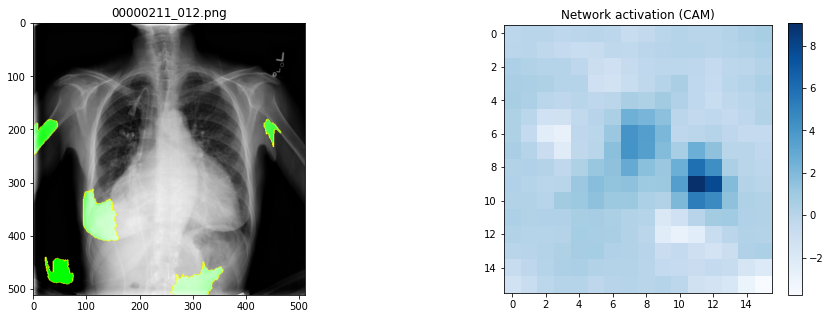

In [35]:
expl = plot_lime_and_activation(FP[5], num_features=5)

100% |########################################################################|


Ground truth: 0
Prediction: 0.9636
R^2 of the linear explanation:  0.28000082303929297


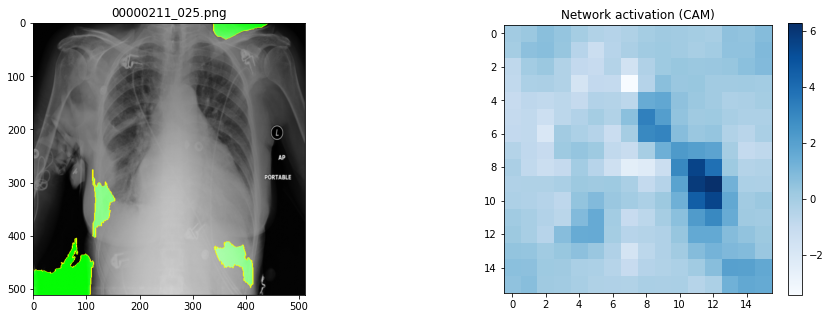

In [36]:
expl = plot_lime_and_activation(FP[6], num_features=5)

100% |########################################################################|


Ground truth: 0
Prediction: 0.7858
R^2 of the linear explanation:  0.34389026877908657


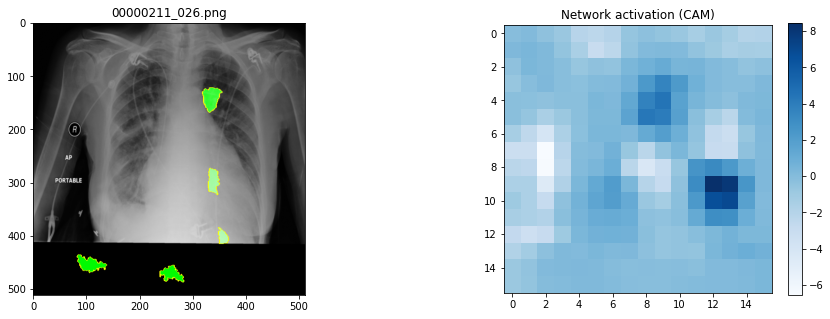

In [37]:
expl = plot_lime_and_activation(FP[7], num_features=5)

## Test with different segmentation fn

In [23]:
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.filters import sobel
from skimage.color import rgb2gray

In [24]:
def seg_fn(img, **params):
    # return felzenszwalb(img, **params)
    return slic(img, **params)

100% |########################################################################|


Ground truth: 0
Prediction: 0.9335
R^2 of the linear explanation:  0.2454868312838927


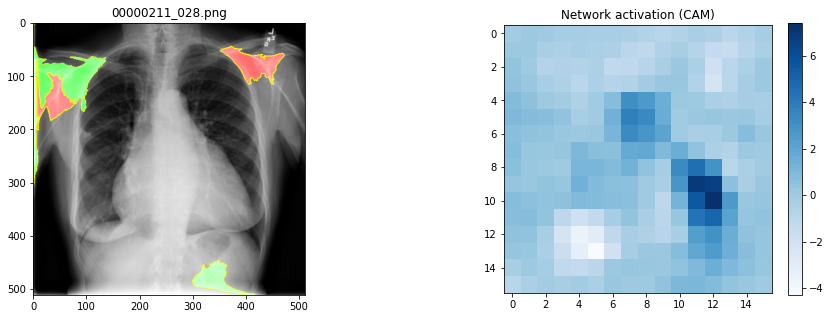

In [81]:
expl = plot_lime_and_activation(FP[8], num_features=5, segmentation_fn=seg_fn)

100% |########################################################################|


Ground truth: 1
Prediction: 0.5837
R^2 of the linear explanation:  0.21377604312748244


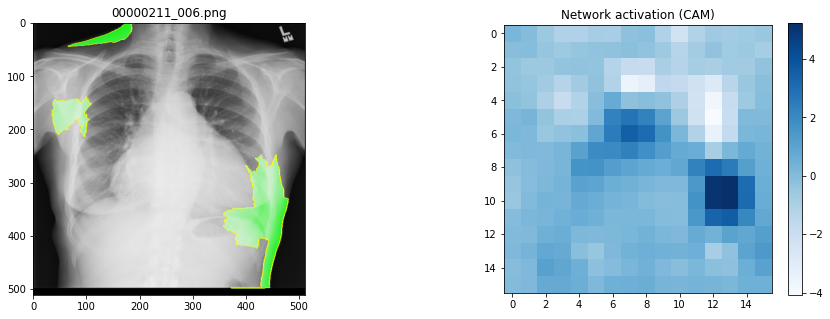

In [80]:
expl = plot_lime_and_activation(TP[4], num_features=5, segmentation_fn=seg_fn)

100% |########################################################################|


Ground truth: 1
Prediction: 0.9282
R^2 of the linear explanation:  0.21215677916203693


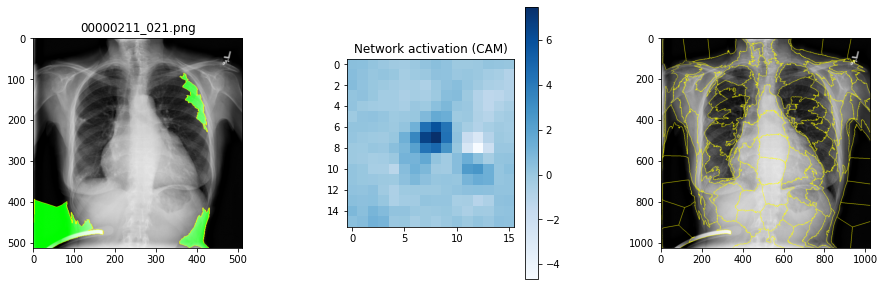

In [96]:
expl = plot_lime_and_activation(TP[10], num_features=5, segmentation_fn=seg_fn, subplots=3)
plt.subplot(1, 3, 3)
plot_segmentation(TP[10])

100% |########################################################################|


Ground truth: 1
Prediction: 1.0000
R^2 of the linear explanation:  0.1963912403642586


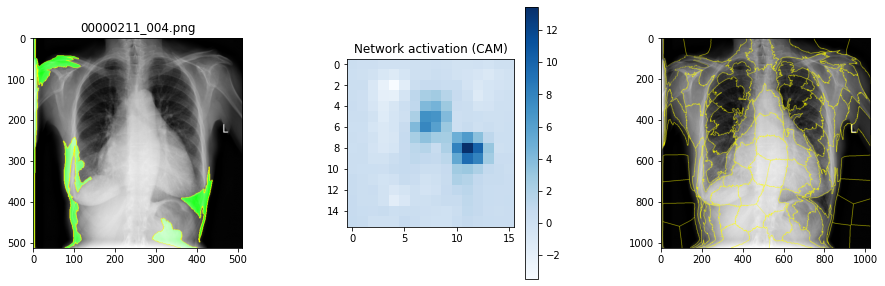

In [95]:
expl = plot_lime_and_activation(TP[2], num_features=5, segmentation_fn=seg_fn, subplots=3)
plt.subplot(1, 3, 3)
plot_segmentation(TP[2])

In [ ]:
print(expl.local_exp[0][:5])

100% |########################################################################|


Ground truth: 0
Prediction: 0.9160
R^2 of the linear explanation:  0.15143685248736427


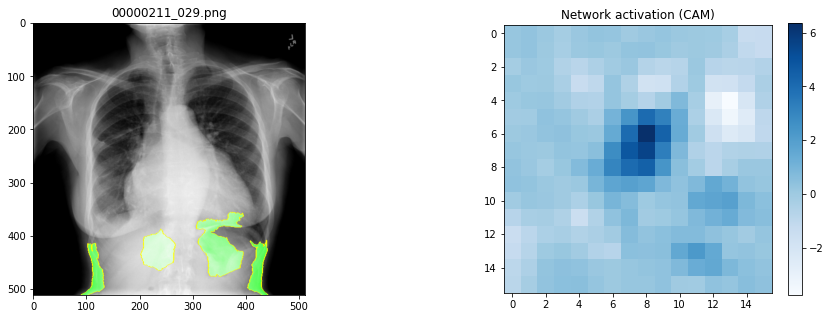

In [90]:
expl = plot_lime_and_activation(FP[9], num_features=5, segmentation_fn=seg_fn)

100% |########################################################################|


Ground truth: 1
Prediction: 0.9998
R^2 of the linear explanation:  0.20252636018008963


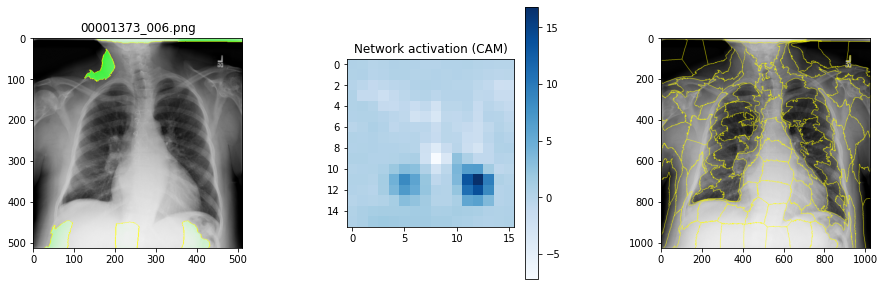

In [97]:
expl = plot_lime_and_activation(TP[20], num_features=5, segmentation_fn=seg_fn, subplots=3)
plt.subplot(1, 3, 3)
plot_segmentation(TP[20])

In [ ]:
image_name = "00008399_007.png"
expl = plot_lime_and_activation(image_name, num_features=5, segmentation_fn=seg_fn, subplots=3)
plt.subplot(1, 3, 3)
plot_segmentation(image_name)

In [84]:
from pprint import pprint

In [85]:
pprint(expl.__dict__)

{'image': array([[[131, 131, 131],
        [108, 108, 108],
        [ 82,  82,  82],
        ...,
        [  3,   3,   3],
        [  3,   3,   3],
        [  1,   1,   1]],

       [[131, 131, 131],
        [107, 107, 107],
        [ 82,  82,  82],
        ...,
        [  3,   3,   3],
        [  3,   3,   3],
        [  1,   1,   1]],

       [[130, 130, 130],
        [106, 106, 106],
        [ 82,  82,  82],
        ...,
        [  3,   3,   3],
        [  3,   3,   3],
        [  1,   1,   1]],

       ...,

       [[149, 149, 149],
        [139, 139, 139],
        [130, 130, 130],
        ...,
        [ 28,  28,  28],
        [ 28,  28,  28],
        [ 15,  15,  15]],

       [[166, 166, 166],
        [157, 157, 157],
        [148, 148, 148],
        ...,
        [ 40,  40,  40],
        [ 40,  40,  40],
        [ 25,  25,  25]],

       [[185, 185, 185],
        [177, 177, 177],
        [169, 169, 169],
        ...,
        [ 55,  55,  55],
        [ 55,  55,  55],
        [ 39, 

In [87]:
# Print values of the top super-pixels
expl.local_exp[0][:10]

[(19, 0.039651534607077585),
 (0, 0.036358045857952354),
 (20, -0.030919418868613546),
 (14, -0.024399165373153616),
 (84, 0.016901922988571513),
 (39, 0.014333766323516723),
 (78, 0.01369699096732053),
 (48, 0.01265657255740657),
 (66, 0.01253440443174298),
 (29, 0.011693576157586615)]

## Try segmentation functions

In [25]:
## TODO: move this up!

def plot_segmentation(image_name):
    img = load_pil_image(image_name)
    segm = slic(img)
    plt.imshow(mark_boundaries(img, segm))

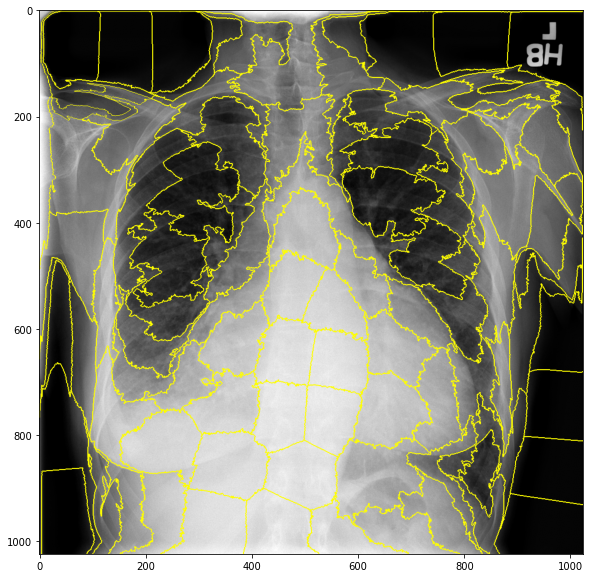

In [73]:
plt.figure(figsize=(20, 10))

img = load_pil_image(TP[3])
# segm = felzenszwalb(img, scale=500)
segm = slic(img)
# segm = quickshift(img, kernel_size=4, max_dist=200, ratio=0.2)

# gradient = sobel(rgb2gray(np.array(img)))
# segm = watershed(gradient)
plt.imshow(mark_boundaries(img, segm))

## Test different distance metrics

100% |########################################################################|


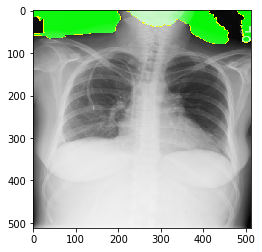

In [45]:
expl = predict_and_explain(image_name, distance_metric="l2")

100% |########################################################################|


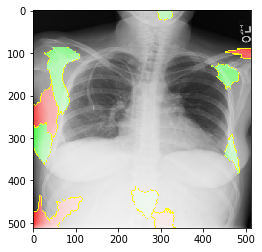

In [50]:
expl = predict_and_explain(image_name, distance_metric="cosine")

# SHAP

In [15]:
import shap

In [16]:
shap.initjs()

In [29]:
from torchvision import transforms
import torch.nn.functional as F

In [27]:
# transf = transforms transforms.Normalize([0.50576189], [1.])
# resize = transforms.Resize(32)

In [17]:
batch_size = 4
height, width = 512, 512

In [35]:
def batch_predict_shap(images):
    bs = int(np.prod(images.shape) / (3*height*width))
    
    batch = torch.Tensor(images.reshape((bs, 3, height, width))).to(device)
     
    preds, _, _ = model(batch)

    return preds.detach().cpu().numpy()

In [36]:
background = np.zeros((4, 3*height*width))

In [37]:
shap_explainer = shap.KernelExplainer(batch_predict_shap, background, link="logit")

In [21]:
batch = next(iter(dataloader))
images = batch[0]

In [22]:
images = images[:1]

In [30]:
images_2 = F.interpolate(images, size=128)
images_2.shape

torch.Size([1, 3, 128, 128])

In [31]:
height, width = 128, 128

In [32]:
images_flatten = np.array(images_2).reshape((1, 3*height*width))
images_flatten.shape

(1, 49152)

In [38]:
shap_values = shap_explainer.shap_values(images_flatten, n_samples=1)
shap_values

MemoryError: Unable to allocate array with shape (100352, 196608) and data type float64